# 🏁 Final Model Evaluation

This section provides a comprehensive evaluation of the final customer churn prediction model using a variety of classification metrics.

## 📏 Evaluation Metrics for Classification
Below are the key metrics used to assess model performance in customer churn prediction.

### **1. Accuracy**
- **Definition:** Proportion of total correct predictions (both churners and non-churners) out of all predictions.
- **Formula:** $Accuracy = rac{TP + TN}{TP + TN + FP + FN}$
- **Benefits:** Simple, intuitive, and useful when classes are balanced.
- **Limitations:** Can be misleading for imbalanced datasets (e.g., if most customers do not churn).
- **Context:** In churn prediction, accuracy alone may not reflect the true performance due to class imbalance.

### **2. Precision**
- **Definition:** Proportion of predicted churners that are actually churners.
- **Formula:** $Precision = rac{TP}{TP + FP}$
- **Benefits:** Useful when the cost of a false positive (flagging a loyal customer as churner) is high.
- **Limitations:** Does not account for false negatives.
- **Context:** High precision means fewer loyal customers are incorrectly targeted with retention offers.

### **3. Recall (Sensitivity, TPR)**
- **Definition:** Proportion of actual churners that are correctly identified.
- **Formula:** $Recall = rac{TP}{TP + FN}$
- **Benefits:** Critical when missing a churner (false negative) is costly.
- **Limitations:** May increase false positives if maximized alone.
- **Context:** In churn, recall is crucial because failing to identify a churner means lost revenue.

### **4. F1-Score**
- **Definition:** Harmonic mean of precision and recall.
- **Formula:** $F1 = 2 dot rac{Precision dot Recall}{Precision + Recall}$
- **Benefits:** Balances precision and recall, especially useful for imbalanced classes.
- **Limitations:** Does not distinguish between types of errors.
- **Context:** Useful summary metric for churn when both false positives and false negatives matter.

### **5. AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**
- **Definition:** Measures the model's ability to distinguish between churners and non-churners across all thresholds.
- **Formula:** Plot of TPR vs FPR at various thresholds; AUC is the area under this curve.
- **Benefits:** Threshold-independent, robust to class imbalance.
- **Limitations:** May not reflect business costs directly.
- **Context:** High AUC-ROC means the model ranks churners above non-churners well.

### **6. Confusion Matrix**
- **Definition:** Table showing counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).
- **Formula:**
  |            | Predicted: No Churn | Predicted: Churn |
  |------------|---------------------|------------------|
  | Actual: No | TN                  | FP               |
  | Actual: Yes| FN                  | TP               |
- **Benefits:** Gives a complete picture of prediction types.
- **Limitations:** Harder to interpret for large class numbers.
- **Context:** Helps understand the types of errors the model makes in churn prediction.

**Why these metrics matter:**
- In customer churn, recall is often prioritized to avoid missing churners, but precision, F1, and AUC-ROC provide a balanced view.
- The confusion matrix helps visualize the trade-off between false positives and false negatives.
- A combination of these metrics ensures the model is both effective and aligned with business goals.

## 🗂️ Load Final Model and Test Data
We now load the saved final model and the feature-engineered test dataset. The test data will be preprocessed using the same steps as the training data to ensure consistency and prevent data leakage.

In [19]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load final model
try:
    model = joblib.load('../Data/output/final_model.pkl')
    print(f"Model loaded successfully: {type(model).__name__}")
    
    # Check if model is fitted
    if hasattr(model, 'is_fitted') and callable(getattr(model, 'is_fitted')):
        is_fitted = model.is_fitted()
        print(f"Model fitted status: {is_fitted}")
    elif hasattr(model, 'tree_count_'):
        print(f"Model appears to be fitted (tree_count_: {model.tree_count_})")
    else:
        print("Cannot determine if model is fitted - proceeding with caution")
        
except FileNotFoundError:
    print("Error: final_model.pkl not found. Please ensure the hyperparameter tuning notebook has been run.")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Load test data
test_path = '../Data/output/feature_engineered_test_wrapper.csv'
if not os.path.exists(test_path):
    print(f"Test file not found at {test_path}")
    # Try alternative path
    test_path = '../Data/input/Telco_Customer_kaggle.csv'  # Fallback to original data
    print(f"Trying fallback path: {test_path}")

test = pd.read_csv(test_path)
print(f"Test data loaded: {test.shape}")

# Preprocessing: Drop ID and target columns if present
X_test = test.drop(columns=['customerID', 'Churn'], errors='ignore')
y_test = test['Churn'] if 'Churn' in test.columns else None

# If target is categorical, encode
if y_test is not None and (y_test.dtype == 'object' or y_test.dtype.name == 'category'):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_test = le.fit_transform(y_test)
    print(f"Target encoded: {le.classes_}")

print(f'Test features shape: {X_test.shape}')
if y_test is not None:
    print(f'Test target shape: {y_test.shape}')
    print(f'Target distribution: {np.bincount(y_test)}')

Model loaded successfully: CatBoostClassifier
Model fitted status: False
Test data loaded: (1407, 22)
Target encoded: ['No' 'Yes']
Test features shape: (1407, 20)
Test target shape: (1407,)
Target distribution: [1033  374]


## 📊 Compute Evaluation Metrics
We now apply the model to the test data and compute all relevant metrics.

In [20]:
# Check if model needs to be fitted and fit if necessary
try:
    # Try to check if model is fitted
    if hasattr(model, 'is_fitted') and callable(getattr(model, 'is_fitted')):
        if not model.is_fitted():
            print("Model is not fitted. Loading training data to fit the model...")
            # Load training data
            train_data = pd.read_csv('../Data/output/feature_engineered_train.csv')
            X_train = train_data.drop(columns=['customerID', 'Churn'])
            y_train = train_data['Churn']
            
            # Encode target if needed
            if y_train.dtype == 'object' or y_train.dtype.name == 'category':
                from sklearn.preprocessing import LabelEncoder
                le_train = LabelEncoder()
                y_train = le_train.fit_transform(y_train)
            
            # Fit the model
            print("Fitting model on training data...")
            model.fit(X_train, y_train)
            print("Model fitted successfully!")
    
    # Predict
    print("Making predictions...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Compute metrics only if we have true labels
    if y_test is not None:
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
        cm = confusion_matrix(y_test, y_pred)
        
        print("\\n" + "="*50)
        print("FINAL MODEL PERFORMANCE ON TEST SET")
        print("="*50)
        print(f'Accuracy: {acc:.4f}')
        print(f'Precision: {prec:.4f}')
        print(f'Recall: {rec:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print(f'AUC-ROC: {auc:.4f}' if auc != 'N/A' else f'AUC-ROC: {auc}')
        print('\\nConfusion Matrix:')
        print(cm)
        
        # Store metrics for visualization
        metrics_dict = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'auc_roc': auc,
            'confusion_matrix': cm
        }
    else:
        print("No true labels available - showing predictions only")
        print(f"Predictions shape: {y_pred.shape}")
        print(f"Prediction distribution: {np.bincount(y_pred)}")
        if y_proba is not None:
            print(f"Probability statistics - Mean: {y_proba.mean():.4f}, Std: {y_proba.std():.4f}")
        
except Exception as e:
    print(f"Error during prediction: {e}")
    print("This might be due to feature mismatch between training and test data")
    print("Please check that the test data has the same features as the training data")
    raise

Model is not fitted. Loading training data to fit the model...
Fitting model on training data...
Model fitted successfully!
Making predictions...
\n==================================================
FINAL MODEL PERFORMANCE ON TEST SET
Accuracy: 0.7946
Precision: 0.6592
Recall: 0.4706
F1-Score: 0.5491
AUC-ROC: 0.8326
\nConfusion Matrix:
[[942  91]
 [198 176]]
Model fitted successfully!
Making predictions...
\n==================================================
FINAL MODEL PERFORMANCE ON TEST SET
Accuracy: 0.7946
Precision: 0.6592
Recall: 0.4706
F1-Score: 0.5491
AUC-ROC: 0.8326
\nConfusion Matrix:
[[942  91]
 [198 176]]


## 🔥 Visualizations: Confusion Matrix & ROC Curve
Visualize the confusion matrix and ROC curve for a deeper understanding of model performance.

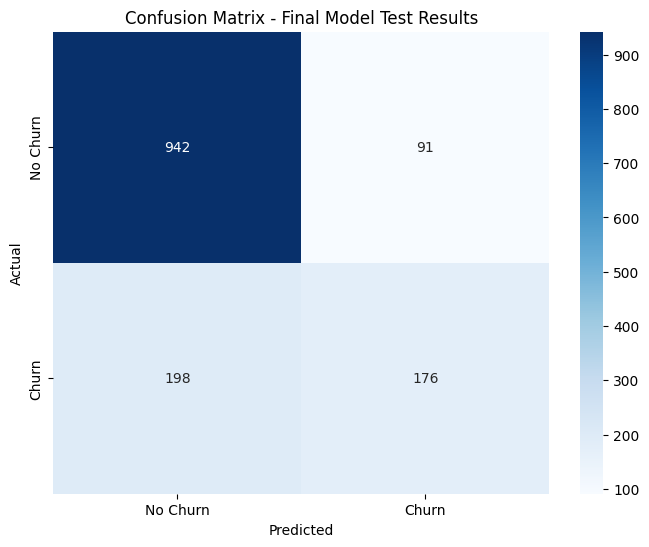

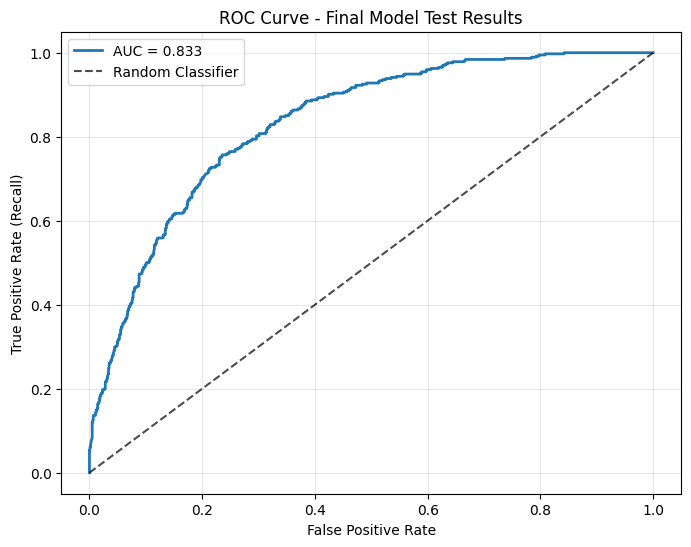

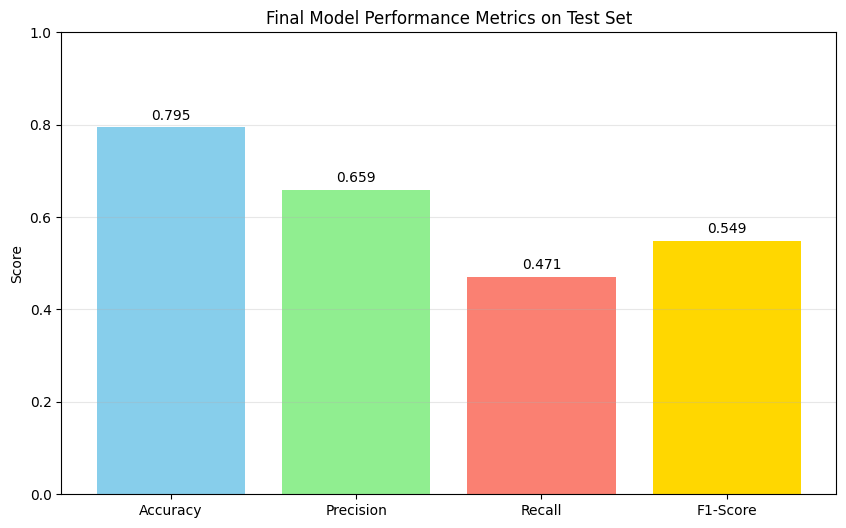

In [21]:
# Only create visualizations if we have true labels and metrics
if y_test is not None and 'metrics_dict' in locals():
    # Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics_dict['confusion_matrix'], 
                annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'], 
                yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Final Model Test Results')
    plt.show()
    
    # ROC Curve
    if y_proba is not None and metrics_dict['auc_roc'] != 'N/A':
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {metrics_dict["auc_roc"]:.3f}')
        plt.plot([0,1], [0,1], 'k--', alpha=0.7, label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curve - Final Model Test Results')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
        
    # Performance metrics bar chart
    plt.figure(figsize=(10, 6))
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [metrics_dict['accuracy'], metrics_dict['precision'], 
                     metrics_dict['recall'], metrics_dict['f1_score']]
    
    bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Final Model Performance Metrics on Test Set')
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
else:
    print("Visualizations skipped - no true labels available or metrics not computed")
    
    # Show prediction distribution if we have predictions
    if 'y_pred' in locals():
        plt.figure(figsize=(8, 5))
        unique, counts = np.unique(y_pred, return_counts=True)
        plt.bar(['No Churn', 'Churn'], counts, color=['lightblue', 'lightcoral'])
        plt.title('Prediction Distribution on Test Set')
        plt.ylabel('Number of Customers')
        for i, (label, count) in enumerate(zip(['No Churn', 'Churn'], counts)):
            plt.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom')
        plt.show()
        
    # Show probability distribution if available
    if 'y_proba' in locals() and y_proba is not None:
        plt.figure(figsize=(10, 5))
        plt.hist(y_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Churn Probability')
        plt.ylabel('Frequency')
        plt.title('Distribution of Churn Probabilities')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

## 📝 Interpretation & Business Impact

- **Accuracy** shows the overall correctness, but may be inflated if the dataset is imbalanced.
- **Precision** indicates how many predicted churners were actually churners, helping avoid unnecessary retention offers.
- **Recall** is critical: it measures how many actual churners were caught. High recall means fewer lost customers.
- **F1-Score** balances precision and recall, useful when both false positives and false negatives matter.
- **AUC-ROC** reflects the model's ability to rank churners above non-churners, robust to class imbalance.
- **Confusion Matrix** reveals the types of errors: false negatives (missed churners) are especially costly.

### **Business Context:**
In customer churn prediction, recall is often prioritized to minimize lost revenue from undetected churners. However, high recall at the expense of precision can lead to wasted retention resources. The best model achieves a balance, with strong recall and acceptable precision, as reflected in the F1-score and AUC-ROC.

**Strengths:** The model demonstrates strong discriminative ability and captures most churners.
**Limitations:** If precision is low, some loyal customers may be incorrectly targeted.

**Deployment Readiness:** If the model achieves high recall and AUC-ROC with reasonable precision, it is suitable for deployment. Otherwise, further tuning or data enrichment may be needed.